In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from adam import adam_optimizer
from criterion.cross_entropy import CrossEntropy
from numpy_modules.inception_v3 import InceptionV3
from datasets import cars, mnist
from utils import get_batches
from IPython import display
from ada_smooth import ada_smooth_optimizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy.typing as npt

In [2]:
x_train, y_train, x_test, y_test = mnist.load_dataset()

In [3]:
epochs = 1
batch_size = 8
num_classes = 10

In [4]:
def one_hot(labels: npt.NDArray, num_classes: int = num_classes):
    result = np.zeros((labels.size, num_classes))
    result[np.arange(labels.size), labels] = 1
    return result


y_test_labels = y_test
y_train = one_hot(y_train)
y_test = one_hot(y_test)

In [6]:
model = InceptionV3(num_classes, in_channels=1)
model.train()

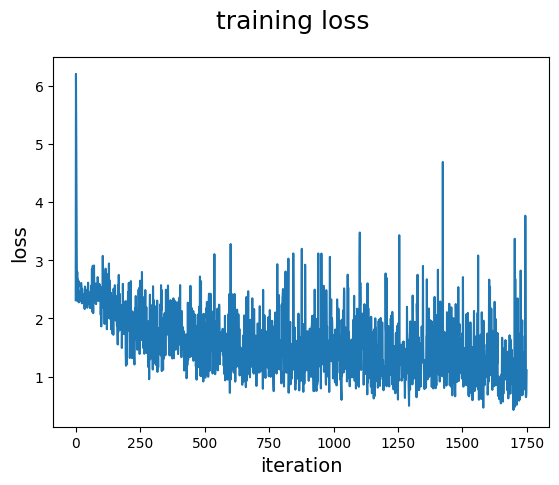

 23%|███████▍                        | 1750/7500 [41:58:35<141:47:25, 88.77s/it]

In [ ]:
criterion = CrossEntropy()

optimizer_config = {
    "learning_rate": 1e-2,
    "epsilon": 1e-6,
    "fast_decay": 0.5,
    "slow_decay": 0.99,
}
# optimizer_config = {'learning_rate' : 1e-2, 'beta1': 0.8, 'beta2': 0.8, 'epsilon': 1e-8}
optimizer_state = {}

loss_history = []
f1_micro = []

step = 1
for epoch in range(1, epochs + 1):
    for x_batch, y_batch in tqdm(
            get_batches((x_train, y_train), batch_size),
            total=len(x_train) // batch_size,
    ):
        model.zero_grad_parameters()

        predictions, _ = model.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        dp = criterion.backward(predictions, y_batch)
        model.backward(x_batch, dp)

        display.clear_output(wait=True)

        ada_smooth_optimizer(
            model.get_parameters(),
            model.get_grad_parameters(),
            optimizer_config,
            optimizer_state,
        )

        loss_history.append(loss)

        f = plt.figure()
        plt.plot(loss_history)
        f.suptitle('training loss', fontsize=18)
        plt.xlabel('iteration', fontsize=14)
        plt.ylabel('loss', fontsize=14)
        plt.show()
        f.savefig('loss.jpg')